In [1588]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import pandas as pd

from utils.basic_utils import read_dates, load_csvs, csv_load
from utils.pricing import *
from utils.fundamental import filter_cols
from matplotlib import pyplot as plt

pd.options.display.float_format = '{:,.3f}'.format

In [1589]:
# utility functions
def top_recomm_by_class(pred_df, labels, top_items):
    mask = pred_df.hard_pred_label == pred_df.soft_pred_label
    agree_df = pred_df.loc[mask].drop_duplicates()
    # should add sector and industries, group for allocation insights
    # should add marketcap, beta, etc, group for risk exposure insights
    label_mask = agree_df.soft_pred_label.isin(['bear', 'short', 'long', 'bull'])
    return agree_df.loc[label_mask]\
        .sort_values(by='soft_confidence', ascending=False)\
        .groupby(by='soft_pred_label').head(top_items)\
        .sort_values(by='soft_pred_class')

def pred_distrib(pred_df, count_col):
    dist = pd.value_counts(pred_df[count_col]).to_frame()
    dist['weights'] = dist / dist.sum()
    return dist

descriptive_cols = {
    'quotes': { 'df': quotes, 'columns': ['shortName', 'forwardPE', 'trailingPE', 'marketCap', 'regularMarketPrice'],},
    'profile': { 'df': profile, 'columns': ['sector', 'industry', 'country'],},
    'keystats': { 'df': keystats, 'columns': ['pegRatio', 'shortPercentOfFloat'],},
    'finstats': { 'df': finstats, 'columns': ['earningsGrowth', 'recommendationMean', 'targetMeanPrice', 'targetMedianPrice', 'numberOfAnalystOpinions'],},
    'valuation': { 'df': val_df, 'columns': ['premDisc', 'growthRate'],},
}

def add_desc_stats(df, descriptive_cols):
    
    tickers = df.index
    for k in descriptive_cols.keys():
        desc_df, cols = descriptive_cols[k]['df'], descriptive_cols[k]['columns']
        for c in cols: df.loc[:, c] = tickers.map(desc_df[c].to_dict()).values 

    df = clean_df(df, large_vals, div_cols)

    df.loc[:, 'pegRatio'] = df.forwardPE / (val_df.growthRate * 100)
    df.loc[:, 'size'] = discret_rets(df.marketCap, mkt_cap_cuts, mkt_cap_labels)
        
    return df

def clean_df(df, large_vals, div_cols):
    # convert large values to billions
    df.loc[:, large_vals] = df.loc[:, large_vals] / 10**9
    df.loc[:, div_cols] = df[div_cols].div(df.regularMarketPrice, axis=0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

def ml_votes_by_class(fndm_dfs, group_mask):
    super_list = []
    for key in fndm_dfs.keys():
        df = fndm_dfs[key]
        super_list.append(
            fndm_dfs[key].loc[:, group_mask].set_index(re_index_col)\
            .rename(columns={group_mask[0]: key}))
    df = pd.concat(super_list, axis=1, sort=False)
    # df.apply(pd.value_counts).loc[fwd_ret_labels].style.background_gradient(cmap='RdYlGn')
    return df.T.apply(pd.value_counts).T

q_group = lambda x, q: x.quantile(q)

ticker_across_mls = lambda ticker: pd.concat(
    [fndm_dfs[key] for key in fndm_dfs.keys()]
    ).set_index('symbol').loc[ticker]

# equal weight ml_confidence
equal_wgt_conf = lambda x: ticker_across_mls(x[0]).loc[:, x[1]].mean()

# take index and class, and calculate a dot product, weighted confidence
score_wgt_conf = lambda x: ticker_across_mls(x[0]).loc[
    :, [x[1], 'model']].set_index('model').T.mul(model_weights).sum(1).iloc[0]

In [1590]:
hard_vote, soft_vote = 'hard_pred_label', 'soft_pred_label'

In [1591]:
# s3 paths
s3_path = {
    'macro': 'recommend/macro_ML/',
    'px_mom': 'recommend/micro_ML/',
    'fin_data': 'recommend/fdmn_ML-fin_data/',
    'key_statistics': 'recommend/fdmn_ML-key_statistics/',
    'eps_trend': 'recommend/fdmn_ML-eps_trend/',
    'eps_estimates': 'recommend/fdmn_ML-eps_estimates/',
    'day_quote': 'recommend/fdmn_ML-day_quote/',
    'iv_value': 'valuation/waterfall/'
}

In [1592]:
# environment variables
bench = '^GSPC'
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

key = 'fin_data'
agg_funcs = ['count', 'median', 'max']
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

re_index_col = 'symbol'
value_col = 'soft_confidence'
show = ['symbol', 'soft_confidence']
mask_col, class_value = 'soft_pred_label', 'bull'

large_vals = ['marketCap']
div_cols = ['targetMeanPrice', 'targetMedianPrice']

In [1593]:
# context / descriptive data
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3

quotes = load_csvs('quote_consol', [tgt_date])
eqty_symbols = quotes[quotes.quoteType == 'EQUITY'].symbol
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date)])
keystats.set_index('symbol', drop=False, inplace=True)
1
finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date)])
finstats.set_index('symbol', drop=False, inplace=True)

Loading file quote/csv/2019-04-08
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-04-08
Loading file summary-categories/financialData/2019-04-08


### Macro / risk-exposure ML

In [1594]:
# Read macro predictions
key = 'macro'
macro_df = pd.read_csv(csv_load(f'{s3_path[key]}{tgt_date}'), index_col='pred_date', parse_dates=True)
macro_df.tail()

,^GSPC,hard_pred_class,hard_pred_label,soft_pred_class,soft_pred_label,soft_confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,,,
2019-04-01,"2,867.190",3,long,3,long,0.482,0.000,0.024,0.454,0.482,0.040
2019-04-02,"2,867.240",3,long,3,long,0.649,0.000,0.014,0.297,0.649,0.040
2019-04-03,"2,873.400",3,long,3,long,0.685,0.000,0.021,0.260,0.685,0.033
2019-04-04,"2,879.390",3,long,3,long,0.667,0.000,0.014,0.298,0.667,0.020
2019-04-08,"2,895.770",3,long,3,long,0.694,0.000,0.028,0.270,0.694,0.008


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/IPython/core/displayhook.py:271: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


'Confidence Mean: 0.891, Median 0.937'

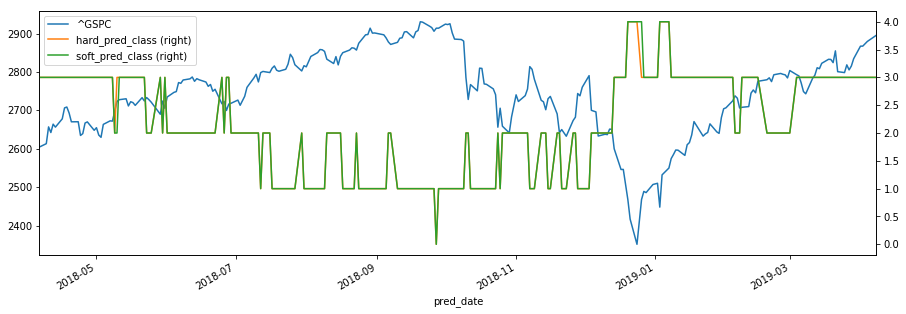

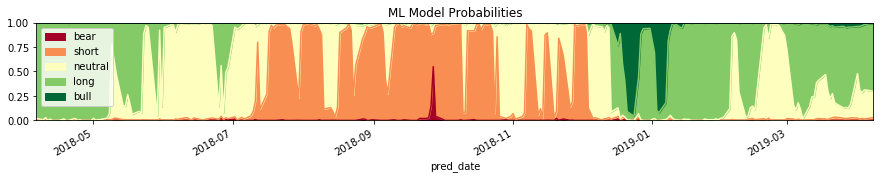

In [1595]:
# Visualize macro predictions
pred_df = macro_df
pre_class_cols = filter_cols(pred_df.columns, "pred_class")
pred_df.loc[:,[bench] + pre_class_cols].plot(
    secondary_y=pre_class_cols, 
    figsize=(15, 5));
pred_df[fwd_ret_labels].plot.area(
        title='ML Model Probabilities',
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn');
f'Confidence Mean: {pred_df["soft_confidence"].mean().round(3)}, Median {pred_df["soft_confidence"].median().round(3)}'

### Bottom-up MLs

In [1597]:
# Read ML predictions
fndm_dfs = {
    k: pd.read_csv(
        csv_load(f'{s3_path[k]}{tgt_date}'), 
        index_col='pred_date', 
        parse_dates=True)\
        for k in ('px_mom', 'fin_data', 'key_statistics', 
                  'eps_trend', 'eps_estimates', 'day_quote')
}
for key in fndm_dfs.keys(): 
    fndm_dfs[key].loc[:, 'model'] = key

PX_MOM, 1179 unique symbols
FIN_DATA, 1154 unique symbols
KEY_STATISTICS, 1207 unique symbols
EPS_TREND, 1202 unique symbols
EPS_ESTIMATES, 1202 unique symbols
DAY_QUOTE, 1301 unique symbols

Class probability distribution across ML models


,px_mom,fin_data,key_statistics,eps_trend,eps_estimates,day_quote
bear,0.104,0.020,0.050,0.028,0.025,0.058
short,0.126,0.258,0.234,0.296,0.269,0.267
neutral,0.013,0.385,0.255,0.264,0.293,0.206
long,0.293,0.317,0.434,0.385,0.382,0.424
bull,0.464,0.020,0.027,0.027,0.032,0.046


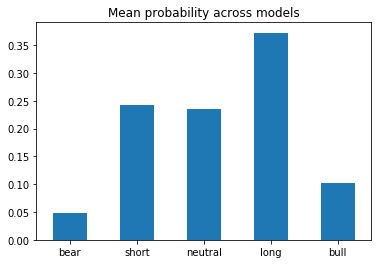

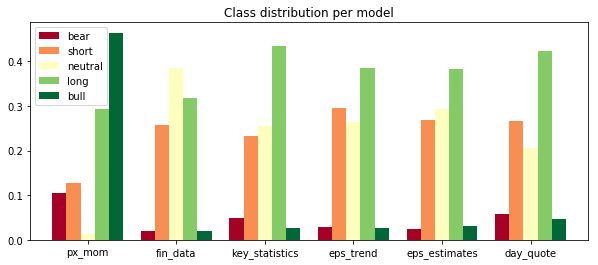

In [1598]:
# Class distribution across models
super_list = []
for key in fndm_dfs.keys():
    df = fndm_dfs[key]
    print(f'{key.upper()}, {df.symbol.shape[0]} unique symbols')
    pred_df = pred_distrib(df, soft_vote).loc[fwd_ret_labels, 'weights']
    pred_df.name = key
    super_list.append(pred_df)
    
class_distrib = pd.concat(super_list, axis=1, sort=True).loc[fwd_ret_labels, :]
class_distrib.mean(axis=1).plot.bar(
    title='Mean probability across models', rot=0)
class_distrib.T.plot.bar(
    title='Class distribution per model', stacked=False, 
    cmap='RdYlGn', figsize=(10,4), width=0.8, rot=0,)

print('\nClass probability distribution across ML models')
class_distrib

#### ML weights

In [1599]:
# Model score weights 
ml_score_dict = {
    'px_mom': 0.75, 'fin_data': 0.75, 'key_statistics': 0.7, 
    'eps_trend': 0.68, 'eps_estimates': 0.65, 
    'day_quote': 0.6, 
    'intrinsic_val': 0.7
}

model_scores = np.array(list(map(ml_score_dict.get, fndm_dfs.keys())))
adj_weights = (model_scores - 0.5) / (model_scores - 0.5).sum()
model_weights = pd.Series({x:y for x,y in zip(fndm_dfs.keys(), adj_weights)})

print('Model weights')
model_weights

Model weights


px_mom           0.221
fin_data         0.221
key_statistics   0.177
eps_trend        0.159
eps_estimates    0.133
day_quote        0.088
dtype: float64

### Filtered recomendations

In [1600]:
# filter settings
min_confidence = 0.55
max_rows = 20

In [1601]:
ml_votes_df = ml_votes_by_class(fndm_dfs, [re_index_col, 'soft_pred_label'])
ml_votes_df = ml_votes_df.loc[ml_votes_df.index.isin(eqty_symbols), :]
min_consensus = ml_votes_df[(ml_votes_df > 3).values]

In [1602]:
label_pos = np.argmax(min_consensus[fwd_ret_labels].fillna(0).values, axis=1)

In [1603]:
vote_df = pd.DataFrame([fwd_ret_labels[x] for x in label_pos], index=min_consensus.index, columns=['class'])
vote_df['ML_probability'] = vote_df.reset_index().apply(score_wgt_conf, axis=1).values
vote_df = add_desc_stats(vote_df, descriptive_cols)

In [1604]:
# Sector level
show_g_by = ['ML_probability', 'forwardPE', 'pegRatio', 'premDisc']
ml_mask = (vote_df['ML_probability'] > min_confidence) & vote_df['class'].isin(show_classes)

grouped = vote_df.loc[ml_mask, :].groupby(by=['class', 'sector'])
grouped.agg(agg_funcs)[show_g_by].sort_values(by=['class',(show_g_by[0],'median')], ascending=False)

ML_probability              forwardPE         \
                                      count median   max     count median   
class sector                                                                
short Financial Services                  3  0.575 0.616         3 13.455   
      Industrials                         1  0.574 0.574         1  9.943   
      Technology                          5  0.554 0.587         5 24.203   
long  Real Estate                        20  0.663 0.753        20 47.192   
      Technology                          6  0.625 0.675         6 23.070   
      Communication Services              4  0.603 0.615         4 18.473   
      Consumer Defensive                  9  0.599 0.709         9 20.621   
      Utilities                           6  0.580 0.668         6 19.859   
      Consumer Cyclical                   4  0.579 0.624         4 24.098   
      Financial Services                  3  0.574 0.636         3 26.424   
      Industrials                         5  0.573 0.601         5 26.610   
      Healthcare                         13  0.572 0.662        13 23.793   

                                     pegRatio               premDisc         \
                                 max    count median    max    count median   
class sector                                                                  
short Financial Services      13.974        2  7.166 12.987        2  0.886   
      Industrials              9.943        0    nan    nan        0    nan   
      Technology              35.269        5  2.226    inf        5  1.995   
long  Real Estate             74.472        3  3.714    inf        3 -3.428   
      Technology             123.909        3  1.015  2.058        3  0.928   
      Communication Services 104.399        4    inf    inf        4  1.973   
      Consumer Defensive      29.483        9  4.074    inf        9  2.180   
      Utilities               26.779        3  3.345  6.519        3  2.138   
      Consumer Cyclical       85.905        2  2.937  5.190        2  1.258   
      Financial Services      30.624        3  1.700  3.481        3  2.809   
      Industrials             48.046        4  2.501  3.071        4  2.897   
      Healthcare              38.461       11  3.718    inf       11  2.879   

                                     
                                max  
class sector                         
short Financial Services      1.483  
      Industrials               nan  
      Technology              2.207  
long  Real Estate            -2.830  
      Technology              1.711  
      Communication Services  2.269  
      Consumer Defensive      4.157  
      Utilities               2.611  
      Consumer Cyclical       1.959  
      Financial Services      2.848  
      Industrials             4.344  
      Healthcare              3.766

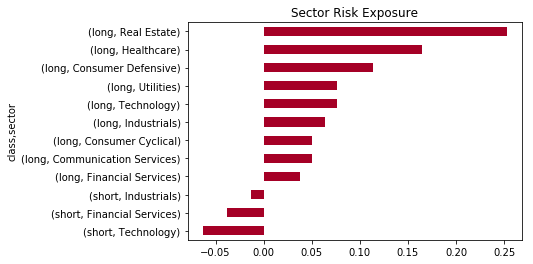

In [1605]:
g_col = grouped.count().iloc[:,1]
(g_col.loc[(['bull', 'long']), :] / g_col.sum())\
    .append((g_col.loc[(['bear', 'short']), :] / g_col.sum()) * -1).sort_values()\
    .plot.barh(title='Sector Risk Exposure', cmap="RdYlGn");

In [1606]:
# Security level
show = ['class','ML_probability','forwardPE', 'industry',
        'targetMedianPrice', 'size']

vote_df.loc[ml_mask & vote_df['class'].isin(['bull', 'long']), :]\
    .sort_values(by='ML_probability', ascending=False)[show].head(max_rows)

,class,ML_probability,forwardPE,industry,targetMedianPrice,size
AVB,long,0.753,39.828,REIT - Residential,1.017,large
CPT,long,0.729,49.388,REIT - Residential,1.032,large
KO,long,0.709,20.684,Beverages - Soft Drinks,1.074,large
FR,long,0.707,45.101,REIT - Industrial,1.010,mid
MAA,long,0.705,47.112,REIT - Residential,0.988,large
REG,long,0.693,42.117,REIT - Retail,1.041,large
KRC,long,0.690,39.448,REIT - Office,1.019,mid
FRT,long,0.690,42.434,REIT - Retail,1.030,large
DLR,long,0.681,74.472,REIT - Office,1.030,large
ARE,long,0.676,54.379,REIT - Office,1.003,large


In [1607]:
vote_df.loc[ml_mask & vote_df['class'].isin(['bear', 'short']), :]\
    .sort_values(by='ML_probability', ascending=False)[show].head(max_rows)

,class,ML_probability,forwardPE,industry,targetMedianPrice,size
NYCB,short,0.616,13.455,Savings & Cooperative Banks,0.971,mid
NOK,short,0.587,13.222,Communication Equipment,1.224,large
VLY,short,0.575,9.676,Banks - Regional - US,1.132,mid
ACM,short,0.574,9.943,Engineering & Construction,1.130,mid
LPL,short,0.574,35.269,Consumer Electronics,0.829,mid
NATI,short,0.554,32.531,Software - Application,1.032,mid
SLAB,short,0.554,24.203,Semiconductors,1.079,mid
CFR,short,0.552,13.974,Banks - Regional - US,0.994,mid
FLIR,short,0.550,18.706,Scientific & Technical Instruments,1.204,mid


#### Company details

In [1608]:
ticker = 'HUYA'

In [1609]:
# Full company detail
vote_df.loc[ticker, :] if ticker in vote_df.index else None

class                                     long
ML_probability                           0.449
shortName                            HUYA Inc.
forwardPE                               30.780
trailingPE                                 NaN
marketCap                                5.160
regularMarketPrice                      25.240
sector                       Consumer Cyclical
industry                   Media - Diversified
country                                  China
pegRatio                                   NaN
shortPercentOfFloat                        NaN
earningsGrowth                             NaN
recommendationMean                       2.400
targetMeanPrice                          1.092
targetMedianPrice                        1.110
numberOfAnalystOpinions                  9.000
premDisc                                   NaN
growthRate                                 NaN
size                                       mid
Name: HUYA, dtype: object

In [1610]:
# Company view across models
wgt_input = (ticker, 'soft_confidence')
print(f'Weighted ML score: {score_wgt_conf(wgt_input)}')
ticker_across_mls(ticker)

Weighted ML score: 0.4493592507921046


,hard_pred_class,hard_pred_label,soft_pred_class,soft_pred_label,soft_confidence,bear,short,neutral,long,bull,model
symbol,,,,,,,,,,,
HUYA,3,long,3,long,0.802,0.055,0.027,0.022,0.802,0.095,fin_data
HUYA,3,long,3,long,0.466,0.141,0.250,0.092,0.466,0.052,key_statistics
HUYA,3,long,3,long,0.518,0.054,0.140,0.138,0.518,0.151,eps_trend
HUYA,3,long,3,long,0.606,0.082,0.062,0.154,0.606,0.096,eps_estimates
HUYA,3,long,3,long,0.298,0.164,0.125,0.183,0.298,0.230,day_quote


#### Top picks by Model

In [1611]:
# Useful for companys missing in multiple models...very early stage
show = ['symbol', 'soft_pred_label','soft_confidence', 'sector']
show_classes = ['bear', 'short', 'long', 'bull']

for key in fndm_dfs.keys():
    df = fndm_dfs[key]
    df.loc[:, 'sector'] = df.symbol.map(profile['sector'].to_dict())
    print(f'Showing results for {key.upper()}')
    print(f'Symbols: {df.symbol.shape[0]}')
    print(top_recomm_by_class(df, show_classes, 3)[show])

Showing results for PX_MOM
Symbols: 1179
           symbol soft_pred_label  soft_confidence              sector
pred_date                                                             
2019-04-08     WY            bear            0.762     Basic Materials
2019-04-08   DWDP            bear            0.729     Basic Materials
2019-04-08    CMD            bear            0.701          Healthcare
2019-04-08    KWR           short            0.639     Basic Materials
2019-04-08    BVN           short            0.603     Basic Materials
2019-04-08    DIS           short            0.483   Consumer Cyclical
2019-04-08     KO            long            0.680  Consumer Defensive
2019-04-08   PYPL            long            0.599  Financial Services
2019-04-08    BLL            long            0.578   Consumer Cyclical
2019-04-08    WTW            bull            0.783   Consumer Cyclical
2019-04-08   CLVS            bull            0.778          Healthcare
2019-04-08    CNX            bull   

### Universe Intrinsic Value Analysis

In [1612]:
path = 'valuation/waterfall/'
print(f'Loading {path}{tgt_date}')
val_df = pd.read_csv(csv_load(path+tgt_date), parse_dates=True)
val_df.set_index('symbol', inplace=True)
val_df.dropna(subset=['premDisc'], inplace=True)
val_df = val_df.loc[(np.abs(val_df.premDisc) < val_df.premDisc.median() * 3).values, :]

iv_mapper = (1 - val_df.loc[(val_df['premDisc'] < 3) & (val_df['premDisc'] > 0), 'premDisc'])

Loading valuation/waterfall/2019-04-08


In [1613]:
iv_show = ['premDisc', 'forwardPE', 'targetMedianPrice', 'pegRatio', 'growthRate']
iv_df = add_desc_stats(iv_mapper.to_frame(), descriptive_cols)
iv_df.groupby(by=['sector', ]).agg(['count', 'min', 'median'])\
    .sort_values(by=(iv_show[0], 'median'))[iv_show]

premDisc              forwardPE                 \
                          count   min median     count     min median   
sector                                                                  
Financial Services           90 0.044  0.403        88   3.930 11.116   
Energy                       20 0.328  0.953        19   6.240 14.425   
Communication Services       11 0.534  1.018        10   4.631 10.312   
Consumer Cyclical            93 0.275  1.284        91   3.995 13.953   
Basic Materials              26 0.424  1.441        26   3.057 14.814   
Technology                  101 0.230  1.579       100 -53.000 18.567   
Industrials                  91 0.096  1.751        88   5.837 15.380   
Healthcare                   48 0.364  1.765        48 -14.392 14.688   
Utilities                    23 0.720  1.793        23   0.017 18.859   
Consumer Defensive           34 0.661  1.912        33   8.133 19.888   
Real Estate                   2 1.282  1.986         2  12.463 17.906   

                       targetMedianPrice              pegRatio                \
                                   count   min median    count    min median   
sector                                                                         
Financial Services                    88 0.547  1.092       88  0.162  1.218   
Energy                                20 0.981  1.182       19  0.086  1.527   
Communication Services                10 0.998  1.188       10  0.563    inf   
Consumer Cyclical                     91 0.769  1.067       91  0.181  2.486   
Basic Materials                       26 0.812  1.093       26  0.658  2.106   
Technology                           101 0.536  1.056      100   -inf  1.511   
Industrials                           90 0.854  1.058       88  0.179  2.802   
Healthcare                            48 0.824  1.104       48 -0.230  1.762   
Utilities                             23 0.833  1.015       23  0.002  3.345   
Consumer Defensive                    34 0.837  1.017       33  0.380  5.365   
Real Estate                            2 1.135  1.159        2  0.828  3.433   

                       growthRate               
                            count   min median  
sector                                          
Financial Services             90 0.000  0.100  
Energy                         20 0.000  0.070  
Communication Services         11 0.000  0.016  
Consumer Cyclical              93 0.000  0.060  
Basic Materials                26 0.000  0.059  
Technology                    101 0.000  0.155  
Industrials                    91 0.000  0.055  
Healthcare                     48 0.000  0.120  
Utilities                      23 0.000  0.052  
Consumer Defensive             34 0.000  0.035  
Real Estate                     2 0.039  0.095

In [1614]:
ml_long = vote_df.loc[ml_mask & vote_df['class'].isin(['bull', 'long'])].index
ml_short = vote_df.loc[ml_mask & vote_df['class'].isin(['bear', 'short'])].index

In [1615]:
iv_df.loc[iv_df.index.isin(ml_long) & (iv_df.premDisc < 1), iv_show].T

symbol,GOOG,GOOGL,SBUX
premDisc,0.928,0.928,0.558
forwardPE,22.036,22.105,24.818
targetMedianPrice,1.142,1.117,0.931
pegRatio,1.012,1.015,0.685
growthRate,0.218,0.218,0.362


In [1616]:
iv_df.loc[iv_df.index.isin(ml_short) & (iv_df.premDisc > 1), iv_show].T

symbol,FLIR,NATI,NYCB,SLAB
premDisc,2.207,1.995,1.483,2.184
forwardPE,18.706,32.531,13.455,24.203
targetMedianPrice,1.204,1.032,0.971,1.079
pegRatio,inf,6.849,12.987,1.336
growthRate,0.000,0.047,0.010,0.181


#### Model audits

In [623]:
# Descriptive statistics for a given model
print(f'Descriptive statistics for {model.upper()}')
fndm_dfs[model].groupby(by=soft_vote).agg(agg_funcs).loc[fwd_ret_labels, 'soft_confidence']

Descriptive statistics for MICRO


,count,mean,median,max
soft_pred_label,,,,
bear,123,0.392,0.362,0.762
short,149,0.325,0.313,0.639
neutral,15,0.311,0.299,0.426
long,345,0.342,0.330,0.680
bull,547,0.388,0.368,0.783


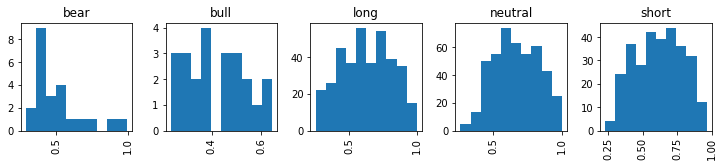

In [861]:
fndm_dfs['fin_data'].loc[:, [soft_vote, 'soft_confidence']].hist(
    by=soft_vote, figsize=(12,2), layout=(1,5));